In [1]:
# activate line execution
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from Bio import pairwise2

In [3]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm

In [221]:
df['careunit'].str.contains('Emergency').sum()
len(df)

6147

18429

In [264]:
df

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime,ts
28734,17656146,20003587,37352363,ED,Emergency Department,2146-04-15 13:35:00,2146-04-15 17:37:21,0.000000
28736,17656146,20003587,33047807,admit,Vascular,2146-04-15 17:37:21,2146-04-15 18:52:08,4.039167
28737,17656146,20003587,37649217,transfer,Vascular,2146-04-15 18:52:08,2146-04-17 08:32:01,5.285556
24058,19669999,20005479,30476020,ED,Emergency Department,2148-06-01 11:16:00,2148-06-01 14:07:00,0.000000
27147,19669999,20005479,32977919,admit,ICU,2148-06-01 14:07:00,2148-06-03 18:30:09,2.850000
...,...,...,...,...,...,...,...,...
43491,16708802,29996606,34034988,admit,ICU,2130-12-05 09:56:00,2130-12-10 18:41:37,5.883333
31536,16853848,29996630,31277139,ED,Emergency Department,2188-11-23 17:39:00,2188-11-24 01:55:07,0.000000
31538,16853848,29996630,31449492,admit,Surgery/Vascular/Intermediate,2188-11-24 01:55:07,2188-11-24 01:58:31,8.268611
31540,16853848,29996630,38448289,transfer,Surgery/Vascular/Intermediate,2188-11-24 10:14:27,2188-11-24 16:01:58,16.590833


In [283]:
PATH = "../resources/sepsis1/core/transfers.csv"

df = pd.read_csv(PATH)
len(df)
df.intime = pd.to_datetime(df.intime)
df.sort_values(by=['hadm_id','intime'], inplace=True)

print(df['careunit'].unique(), len(df['careunit'].unique()))

df['ts'] = df.groupby('hadm_id')['intime'].apply(lambda x: (x-x.iloc[0])).apply(lambda x: x.total_seconds()/3600)

df = df[df.ts <= 48]

df = df[df['careunit'].notnull()]

df = df[~df['careunit'].str.contains('Medicine')]
df.loc[df['careunit'].str.contains('ICU') , 'careunit' ]='ICU'

len(df)

43834

['Emergency Department' 'Vascular'
 'Cardiac Vascular Intensive Care Unit (CVICU)' nan
 'Medical Intensive Care Unit (MICU)' 'Medicine' 'Trauma SICU (TSICU)'
 'Neuro Surgical Intensive Care Unit (Neuro SICU)'
 'Medicine/Cardiology Intermediate' 'Med/Surg'
 'Medical/Surgical (Gynecology)'
 'Medical/Surgical Intensive Care Unit (MICU/SICU)' 'Med/Surg/Trauma'
 'Surgical Intensive Care Unit (SICU)' 'PACU' 'Transplant'
 'Coronary Care Unit (CCU)' 'Medicine/Cardiology' 'Hematology/Oncology'
 'Med/Surg/GYN' 'Cardiac Surgery' 'Labor & Delivery'
 'Obstetrics (Postpartum & Antepartum)' 'Surgery'
 'Hematology/Oncology Intermediate' 'Surgery/Pancreatic/Biliary/Bariatric'
 'Surgery/Trauma' 'Neurology' 'Emergency Department Observation'
 'Neuro Intermediate' 'Cardiology Surgery Intermediate'
 'Surgery/Vascular/Intermediate' 'Obstetrics Postpartum' 'Neuro Stepdown'
 'Thoracic Surgery' 'Obstetrics Antepartum' 'Observation' 'Unknown'
 'Cardiology'] 39


C:\Users\hokarami\AppData\Local\Temp\ipykernel_30844\3747054601.py:10: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



17717

In [284]:
D = df.groupby('hadm_id')[['careunit','ts']].apply(lambda x: x.values.tolist()[:]).tolist()



D = [[(x[1],x[0]) for x in d] for d in D]

D[0]



[(0.0, 'Emergency Department'),
 (4.039166666666667, 'Vascular'),
 (5.285555555555556, 'Vascular'),
 (42.95027777777778, 'ICU')]

## icd codes

In [130]:
df

,subject_id,hadm_id,seq_num,icd_code,icd_version
15035,17656146,20003587,1,0389,9
15032,17656146,20003587,2,78552,9
15031,17656146,20003587,3,5856,9
15028,17656146,20003587,4,51881,9
14944,17656146,20003587,5,7854,9
...,...,...,...,...,...
172176,16853848,29996630,14,Z7901,10
172184,16853848,29996630,15,Z8542,10
172171,16853848,29996630,16,E279,10
172168,16853848,29996630,17,E11649,10


In [129]:
PATH = "../resources/sepsis1/hosp/diagnoses_icd.csv"

df = pd.read_csv(PATH)

df.sort_values(by=['hadm_id','seq_num'], inplace=True)




In [131]:
D = df.groupby('hadm_id')[['seq_num','icd_code']].apply(lambda x: x.values.tolist()[:-1]).tolist()




D[0]

[[1, '0389   '],
 [2, '78552  '],
 [3, '5856   '],
 [4, '51881  '],
 [5, '7854   '],
 [6, '6826   '],
 [7, '42832  '],
 [8, '40391  '],
 [9, '29532  '],
 [10, '2762   '],
 [11, '70714  '],
 [12, '6827   '],
 [13, '99762  '],
 [14, '99592  '],
 [15, '4280   '],
 [16, '4240   '],
 [17, '25040  '],
 [18, '25050  '],
 [19, '36201  '],
 [20, '25060  '],
 [21, '3572   '],
 [22, '25070  '],
 [23, '44381  '],
 [24, 'V5867  ']]

In [285]:
def edit_distance(s1, s2):
    """
    Computes the edit distance (Levenshtein distance) between two sequences of events.
    """

    # s1 = [x for x in s1 if str(x)!='nan']

    # s2 = [x for x in s1 if str(x)!='nan']
    n, m = len(s1), len(s2)
    dp = [[0] * (m+1) for _ in range(n+1)]
    for i in range(n+1):
        dp[i][0] = i
    for j in range(m+1):
        dp[0][j] = j
    for i in range(1, n+1):
        for j in range(1, m+1):
            if s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
    return dp[n][m]

In [286]:
# import torch

def dtw(s, t):
    """
    Computes the dynamic time warping distance between two sequences s and t using PyTorch.

    Args:
        s (Tensor): A 1D tensor representing the first sequence.
        t (Tensor): A 1D tensor representing the second sequence.

    Returns:
        The dynamic time warping distance between s and t as a float.
    """
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n + 1, m + 1))
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.abs(s[i - 1] - t[j - 1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j], dtw_matrix[i, j - 1], dtw_matrix[i - 1, j - 1])
    return dtw_matrix[-1, -1]

In [287]:
def jaccard_similarity(set1, set2):
    """
    Calculates the Jaccard similarity coefficient between two sets.

    Args:
        set1 (set): The first set.
        set2 (set): The second set.

    Returns:
        float: The Jaccard similarity coefficient between the two sets.
    """
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

In [288]:
s = set([1, 2, 3, 4, 5])
t = set([1, 3, 5])

s = set([1, 2, 3, 4])
t = set([2, 3, 5, 6])
print(jaccard_similarity(s, t))  # Output: 1.0

0.3333333333333333


In [289]:
i, j= 112, 401

s1 = [x[1] for x in D[i] if str(x[1])!='nan']
s2 = [x[1] for x in D[j] if str(x[1])!='nan']

s1, s2

edit_distance(s1, s2)

(['ICU', 'ICU'], ['Emergency Department', 'ICU'])

1

In [290]:
n = len(D)
n=1000
dist = np.zeros((n, n))
for i in tqdm(range(n)):
    for j in range(i+1, n):
        s1 = [x[1] for x in D[i] if str(x[1])!='nan']
        s2 = [x[1] for x in D[j] if str(x[1])!='nan']
        dist[i,j] = edit_distance(s1, s2)
        
        
        # s1 = set( [x[1] for x in D[i] if str(x[1])!='nan'] )
        # s2 = set( [x[1] for x in D[j] if str(x[1])!='nan'] )
        # dist[i,j] = jaccard_similarity(s1, s2)
        
        
        dist[j,i] = dist[i,j]  # the distance matrix is symmetric

100%|██████████| 1000/1000 [00:07<00:00, 139.88it/s]


In [274]:
lens = np.array([len(d) for d in D])
lens.min(), lens.max(), lens.mean(), lens.std()

(1, 8, 2.2299404233743187, 0.968700699913708)

In [275]:
temp = dist[dist!=0]
temp.min(), temp.max(), temp.mean(), temp.std()

(1.0, 7.0, 2.093406016301151, 0.9857224833309446)

1.0


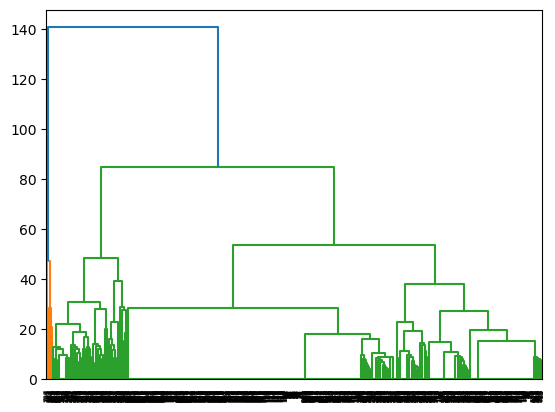

In [291]:
from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import numpy as np

# Calculate the Jaccard similarity

# Define the dataset
data = np.array([
    [0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0],
    [1, 1, 0, 0, 1],
    [0, 1, 0, 0, 1],
    [0, 0, 1, 1, 0]
])


print(jaccard_similarity(set(data[1]), set(data[4])))  # Output: 1.0

jaccard_sim = pdist(data, metric='jaccard')
jaccard_sim = 1-dist
# Construct the dendrogram
linkage_matrix = linkage(jaccard_sim, method='complete')


out = dendrogram(linkage_matrix)

# Determine the number of clusters
# Assign data points to clusters
# ...

In [292]:
out.keys()
out['leaves']

for id in out['leaves']:
    print([ x[1] for x in D[id] ])


dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list', 'leaves_color_list'])

[707,
 767,
 199,
 685,
 3,
 23,
 722,
 855,
 204,
 134,
 293,
 904,
 804,
 879,
 213,
 263,
 240,
 957,
 615,
 807,
 741,
 610,
 965,
 635,
 699,
 940,
 841,
 829,
 799,
 731,
 724,
 597,
 572,
 537,
 400,
 345,
 78,
 285,
 798,
 706,
 350,
 63,
 24,
 60,
 140,
 948,
 571,
 207,
 539,
 239,
 623,
 91,
 141,
 901,
 67,
 72,
 61,
 759,
 488,
 913,
 508,
 954,
 255,
 747,
 295,
 701,
 789,
 918,
 502,
 0,
 430,
 778,
 8,
 547,
 478,
 647,
 553,
 253,
 745,
 189,
 849,
 844,
 307,
 165,
 541,
 118,
 311,
 396,
 480,
 142,
 164,
 184,
 847,
 368,
 876,
 780,
 284,
 695,
 733,
 139,
 868,
 958,
 929,
 212,
 928,
 694,
 739,
 270,
 168,
 187,
 522,
 599,
 114,
 735,
 660,
 299,
 608,
 76,
 762,
 883,
 968,
 428,
 859,
 259,
 354,
 603,
 181,
 805,
 104,
 280,
 717,
 936,
 410,
 812,
 392,
 355,
 120,
 251,
 681,
 963,
 51,
 775,
 951,
 505,
 748,
 446,
 649,
 970,
 834,
 526,
 607,
 322,
 566,
 872,
 605,
 819,
 47,
 373,
 595,
 4,
 79,
 109,
 564,
 626,
 995,
 994,
 993,
 987,
 986,
 984,
 

['Emergency Department', 'ICU', 'ICU', 'Surgery', 'Surgery', 'Surgery', 'Surgery']
['Emergency Department', 'Coronary Care Unit (CCU)', 'Emergency Department Observation', 'ICU', 'Emergency Department Observation', 'ICU', 'ICU']
['Emergency Department', 'ICU', 'Surgery/Pancreatic/Biliary/Bariatric', 'Surgery/Pancreatic/Biliary/Bariatric', 'Surgery/Pancreatic/Biliary/Bariatric', 'ICU']
['Emergency Department', 'ICU', 'Emergency Department Observation', 'ICU', 'Emergency Department Observation', 'ICU']
['Emergency Department', 'ICU', 'ICU', 'ICU', 'ICU', 'ICU']
['Emergency Department', 'ICU', 'ICU', 'ICU', 'PACU', 'ICU']
['Hematology/Oncology', 'ICU', 'ICU', 'Hematology/Oncology', 'ICU']
['ICU', 'ICU', 'ICU', 'Med/Surg', 'Med/Surg']
['Emergency Department', 'Med/Surg', 'Med/Surg', 'Med/Surg', 'Hematology/Oncology']
['Labor & Delivery', 'Obstetrics Postpartum', 'Labor & Delivery', 'ICU', 'Obstetrics Postpartum']
['Emergency Department', 'Emergency Department Observation', 'ICU', 'Coronary

In [293]:
clustering  = AgglomerativeClustering(n_clusters=None,distance_threshold = 10, metric='euclidean').fit(dist)

c:\Users\hokarami\Anaconda3\envs\datavis1\lib\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [294]:
(clustering.labels_)

array([38, 31, 31, 25, 78, 16, 50, 48, 21, 43, 27, 31, 71, 43, 31, 29, 43,
       31, 43, 31, 43,  3, 71, 25, 96, 31, 43, 31, 50, 48, 45, 16, 31, 31,
       23, 31, 65, 31, 71, 29, 43, 31, 65, 83, 43, 43, 31,  5, 31, 43, 77,
       42, 29, 83, 31, 45, 43, 31, 43, 31, 96, 44, 29, 96, 13, 31, 43, 88,
       31, 31, 43, 31, 88, 31, 31, 31, 32, 23, 69, 78, 31, 31, 31, 31, 71,
       31, 10, 31, 24, 43, 31, 36, 31, 31, 31, 29, 29, 31, 43, 31, 43, 31,
       31, 16,  1, 31, 31, 31, 77,  8, 31, 77, 37, 31,  0, 83, 71, 29, 75,
       43, 18, 50, 50, 31, 31, 71, 71, 62, 31, 92, 31, 31, 31, 31, 89, 43,
       71, 31,  3, 52,  9, 36, 26, 31, 43, 31, 43, 29, 31, 71, 27, 31, 31,
       31, 31, 31, 13, 29, 43, 45, 31, 31, 71, 61, 26, 14, 31, 31, 15, 43,
       31, 31, 29, 31, 71, 31, 31, 31, 29, 31, 29,  1, 33, 71, 86, 31, 31,
       15, 43,  6, 31, 13, 31, 71, 31, 29, 31, 37, 31, 81, 23,  3, 28, 31,
       79, 45, 71, 54, 10, 43, 31, 23, 17, 20, 71, 40, 31, 31, 31, 31, 13,
       43, 31, 31, 31, 31

In [297]:
len(np.unique(clustering.labels_))

clustering.n_clusters

x = np.where(clustering.labels_==43)[0]
x
dist[x,:][:,x]
for j in x:
    [tt[1] for tt in D[j]]


    

100

array([  9,  13,  16,  18,  20,  26,  40,  44,  45,  49,  56,  58,  66,
        70,  89,  98, 100, 119, 135, 144, 146, 158, 169, 188, 209, 221,
       233, 236, 274, 300, 304, 312, 319, 323, 328, 331, 332, 333, 335,
       352, 353, 363, 365, 366, 369, 371, 378, 390, 391, 404, 406, 429,
       433, 441, 445, 449, 468, 475, 487, 492, 527, 529, 561, 563, 576,
       579, 581, 616, 634, 659, 679, 682, 688, 698, 703, 714, 716, 730,
       737, 740, 743, 750, 766, 768, 772, 784, 785, 811, 814, 821, 822,
       827, 835, 848, 874, 875, 878, 881, 886, 887, 890, 902, 903, 906,
       921, 939, 966, 971, 976, 979, 982, 998], dtype=int64)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

['ICU']

In [124]:
x = np.where(clustering.labels_==513)[0]
x
dist[x,:][:,x]
for j in x:
    [tt[1] for tt in D[j]]

array([2], dtype=int64)

array([[0.]])

['Emergency Department', 'Trauma SICU (TSICU)', 'Medicine', 'Medicine']

C:\Users\hokarami\AppData\Local\Temp\ipykernel_30844\405223605.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist, 'ward')


<Figure size 1000x700 with 0 Axes>

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [12.5, 12.5, 42.5, 42.5],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [95.0, 95.0, 105.0, 105.0],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [100.0, 100.0, 122.5, 122.5],
  [72.5, 72.5, 111.25, 111.25],
  [27.5, 27.5, 91.875, 91.875],
  [155.0, 155.0, 165.0, 165.0],
  [175.0, 175.0, 185.0, 185.0],
  [160.0, 160.0, 180.0, 180.0],
  [145.0, 145.0, 170.0, 170.0],
  [195.0, 195.0, 205.0, 205.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [215.0, 215.0, 232.5, 232.5],
  [200.0, 200.0, 223.75, 223.75],
  [157.5, 157.5, 211.875, 211.875],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [335.0, 335.0, 345.0, 345.0],
  [325.0, 325.0, 340.0, 340.0],
  [315.0, 315.0, 332.5, 332.5],
  [365.0, 365.0, 375.0, 375.0],
  [355.0, 355.0, 370.0, 

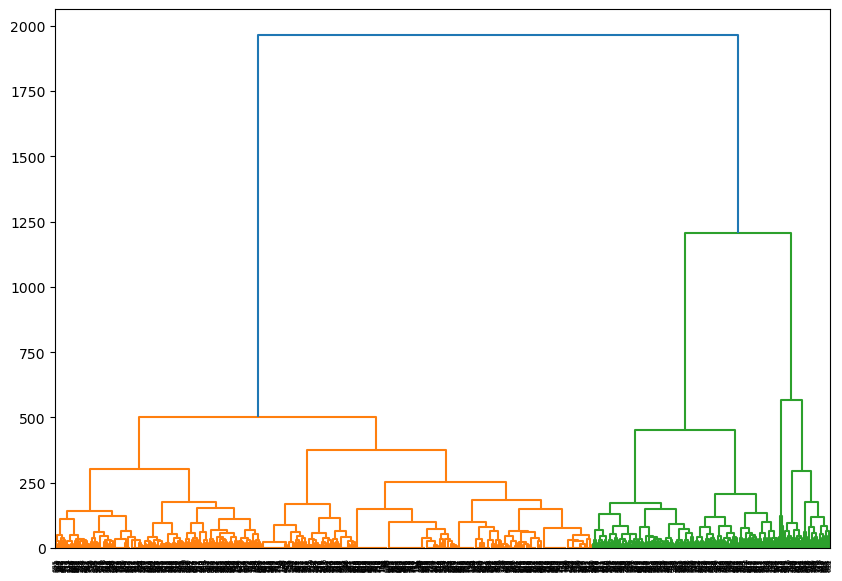

In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(dist, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.show()

In [239]:
import plotly.graph_objects as go
import urllib, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())

In [248]:
data['data'][0]['link']

{'source': [0,
  1,
  1,
  1,
  1,
  6,
  7,
  8,
  10,
  9,
  11,
  11,
  11,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  23,
  25,
  5,
  5,
  5,
  5,
  5,
  27,
  17,
  17,
  28,
  29,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  34,
  24,
  35,
  35,
  36,
  38,
  37,
  39,
  39,
  40,
  40,
  41,
  42,
  43,
  43,
  4,
  4,
  4,
  26,
  26,
  26,
  44,
  45,
  46,
  47,
  35,
  35],
 'target': [1,
  2,
  3,
  4,
  5,
  2,
  4,
  9,
  9,
  4,
  12,
  13,
  14,
  16,
  14,
  17,
  12,
  18,
  19,
  13,
  3,
  20,
  21,
  22,
  24,
  24,
  13,
  3,
  26,
  19,
  12,
  15,
  28,
  3,
  18,
  15,
  12,
  30,
  18,
  31,
  32,
  19,
  33,
  20,
  1,
  5,
  26,
  26,
  37,
  37,
  2,
  4,
  1,
  14,
  13,
  15,
  14,
  42,
  41,
  19,
  26,
  12,
  15,
  3,
  11,
  15,
  1,
  15,
  15,
  26,
  26],
 'value': [124.729,
  0.597,
  26.862,
  280.322,
  81.144,
  35,
  35,
  11.606,
  63.965,
  75.571,
  10.639,
  22.505,
  46.184,
  104.453,
  113.726,
  27.14,
  342.16